<h1 align="center"> <span style="font-size: 20px;"> Proyecto Final Grupo Nº 7 </span> <br>
    <align="center"> <span style="font-size: 15px;">  Proyecto Yelp & Google Maps - Reviewa y Recomendaciones</span><br>         
<align="center"> <span style="font-size: 15px;">@utores:  Javier Castro, Luca Ramallo, Luis Ramírez, Lesmen García.</span> <br>
  <a href="https://github.com/lesmengp/Proyecto-Final-Grupo-07.git">GitHub: <span style="font-size: 20px;">Proyecto Yelp & Google Maps</span></a> 
</h1>

# Consolidando Final para el Modelo de ML.

### Librerías a Utilizar:

In [2]:
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.8/636.8 kB 10.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.1 MB/s eta 0:00:00
  Obtaining dependency information for regex>=2021.8.3 from https://files.pythonhosted.org/packages/8f/3e/4b8b40eb3c80aeaf360f0361d956d129bb3d23b2a3ecbe3a04a8f3bdd6d3/regex-2023.10.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 773.9/773.9 kB 49.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import json
import gcsfs
import ast
from textblob import TextBlob   #0.17.1
import pandas as pd
import folium
import webbrowser
import textwrap
from folium.plugins import MarkerCluster

### Definición de Funciones

In [9]:
#############################################
### Funcion para Visualizar Valores Nulos ###
#############################################

def ValoresNulos(columnas,datasets):
    for dataset in datasets:
        df = globals()[dataset]
        print(f"Información del DataSets: {datasets}")
        print("="*80)
        for columna in columnas:
            print(f"Analizando los Valores Nulos en la Columna:   '{columna}'")
            print(f"Total Registros: {df.shape[0]}")
            print(f"Total Valores Nulos: {df[columna].isna().sum()}")
            print(f"Porcentaje Valores Nulos: {round((df[columna].isna().sum()/df.shape[0])*100,3)} %")
            print("="*80)

In [10]:
#####################################################
### Funcion para Eliminar Filas con Valores Nulos ###
#####################################################

def EliminarRegistrosValoresNulos(columnas,datasets):
    for dataset in datasets:
        for columna in columnas:
            df = globals()[dataset]
            df.dropna(subset=columna, inplace=True)
    df.info()

In [11]:
#################################################
### Funcion para Visualizar Columnas Anidadas ###
#################################################

def VisualizarColumnas(columnas,datasets):
    pd.set_option('display.max_colwidth', None)
    for dataset in datasets:
        for columna in columnas:
            df = globals()[dataset]
            print(f"{df[columna]}\n")
            print(f"Tipo de Columna:, {type(df[columna])}")
            print("="*80)
    pd.reset_option('display.max_colwidth')

### Cargando Dataset Consolidado para ML: 'df_ML_promedios.parquet'

In [63]:
### Cargando DataSets Consolidado para Análisis de ML: 'df_business_yelp_ML.parquet'
# Ruta completa en Cloud Storage
ruta_eda_datalike = "gs://gmy/Datasets_ML/df_ML_promedios.parquet"

# Lee el archivo Parquet directamente en un DataFrame de pandas
df_ML_promedios = pd.read_parquet(ruta_eda_datalike, storage_options={"project": "Proyecto Final - Henry"})
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49334 entries, 0 to 49333
Data columns (total 39 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   business_id                         49334 non-null  object 
 1   name                                49334 non-null  object 
 2   address                             49334 non-null  object 
 3   city                                49334 non-null  object 
 4   state                               49334 non-null  object 
 5   postal_code                         49334 non-null  object 
 6   latitude                            49334 non-null  float64
 7   longitude                           49334 non-null  float64
 8   stars                               49334 non-null  float64
 9   review_count                        49334 non-null  int16  
 10  is_open                             49334 non-null  int8   
 11  RestaurantsTakeOut                  46461

In [64]:
df_ML_promedios.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'RestaurantsTakeOut', 'BusinessParking', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'average_stars', 'total_sentimientos',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'total_sentimientosTip', 'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip'],
      dtype='object')

### Definiendo Horarios de Atención de los Restaurantes para intervalos de tiempo "Mañana", "Tarde" y "Noche".

In [65]:
### Definir los intervalos de tiempo para "Mañana", "Tarde" y "Noche"

# Encoding para Abierto (True) y Cerrado (False)
# 1 = Abierto
# 0 = Cerrado

# Definición de la Duración de los Intervados
intervalo_manana = ("6:0", "11:59")
intervalo_tarde = ("12:0", "17:59")
intervalo_noche = ("18:0", "23:59")

# Función para evaluar si un horario está dentro del intervalo
def horario_en_intervalo(horario, intervalo):
    hora_inicio, hora_fin = intervalo
    hora, minuto = horario.split(":")
    hora = int(hora)
    minuto = int(minuto)
    return hora >= int(hora_inicio.split(":")[0]) and hora <= int(hora_fin.split(":")[0])

# Crear características "Abierto_Mañana", "Abierto_Tarde" y "Abierto_Noche" para cada día de la semana
for dia in ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]:
    df_ML_promedios[f"A_M_{dia}"] = df_ML_promedios[dia].apply(lambda x: horario_en_intervalo(x.split("-")[0], intervalo_manana))
    df_ML_promedios[f"A_T_{dia}"] = df_ML_promedios[dia].apply(lambda x: horario_en_intervalo(x.split("-")[0], intervalo_tarde))
    df_ML_promedios[f"A_N_{dia}"] = df_ML_promedios[dia].apply(lambda x: horario_en_intervalo(x.split("-")[0], intervalo_noche))
    
df_ML_promedios

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,A_N_Thursday,A_M_Friday,A_T_Friday,A_N_Friday,A_M_Saturday,A_T_Saturday,A_N_Saturday,A_M_Sunday,A_T_Sunday,A_N_Sunday
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,False,True,False,False,True,False,False,True,False,False
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,False,False,True,False,False,True,False,False,True,False
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,AZ,37015,36.269593,-87.058943,2.0,6,...,False,True,False,False,True,False,False,True,False,False
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,MO,37207,36.208102,-86.768170,1.5,10,...,False,True,False,False,True,False,False,True,False,False
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,MO,33602,27.955269,-82.456320,4.0,10,...,False,True,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49329,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,...,False,False,False,False,False,False,False,False,False,False
49330,1jx1sfgjgVg0nM6n3p0xWA,Savaya Coffee Market,11177 N Oracle Rd,Oro Valley,PA,85737,32.409552,-110.943073,4.5,41,...,False,True,False,False,True,False,False,True,False,False
49331,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,MO,19147,39.935982,-75.158665,4.5,35,...,False,True,False,False,True,False,False,True,False,False
49332,2O2K6SXPWv56amqxCECd4w,The Plum Pit,4405 Pennell Rd,Aston,PA,19014,39.856185,-75.427725,4.5,14,...,False,False,False,False,False,False,False,False,False,False


In [66]:
df_ML_promedios.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'RestaurantsTakeOut', 'BusinessParking', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'average_stars', 'total_sentimientos',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'total_sentimientosTip', 'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday',
       'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
       'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday',
   

### Calculando el número de Horas Totales que un Restaurant atiende Semanalmente.

In [67]:
###  Función para calcular la duración en horas de un horario
def calcular_duracion_horas(horario):
    horarios = horario.split('-')
    hora_apertura = datetime.strptime(horarios[0], "%H:%M")
    hora_cierre = datetime.strptime(horarios[1], "%H:%M")
    duracion = hora_cierre - hora_apertura
    return duracion.total_seconds() / 3600  # Duración en horas

# Calcular la duración diaria y sumar para obtener el total semanal
dias_semana = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_ML_promedios[dias_semana] = df_ML_promedios[dias_semana].applymap(calcular_duracion_horas)
df_ML_promedios['Total_Horas_Semana'] = df_ML_promedios[dias_semana].sum(axis=1)

# Resultado: DataFrame con el total de horas trabajadas durante la semana
df_ML_promedios

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,A_M_Friday,A_T_Friday,A_N_Friday,A_M_Saturday,A_T_Saturday,A_N_Saturday,A_M_Sunday,A_T_Sunday,A_N_Sunday,Total_Horas_Semana
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,...,True,False,False,True,False,False,True,False,False,94.0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,MO,18054,40.338183,-75.471659,4.5,13,...,False,True,False,False,True,False,False,True,False,40.0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,AZ,37015,36.269593,-87.058943,2.0,6,...,True,False,False,True,False,False,True,False,False,66.0
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,MO,37207,36.208102,-86.768170,1.5,10,...,True,False,False,True,False,False,True,False,False,76.0
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,MO,33602,27.955269,-82.456320,4.0,10,...,True,False,False,False,False,False,False,True,False,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49329,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,...,False,False,False,False,False,False,False,False,False,17.0
49330,1jx1sfgjgVg0nM6n3p0xWA,Savaya Coffee Market,11177 N Oracle Rd,Oro Valley,PA,85737,32.409552,-110.943073,4.5,41,...,True,False,False,True,False,False,True,False,False,50.0
49331,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,MO,19147,39.935982,-75.158665,4.5,35,...,True,False,False,True,False,False,True,False,False,26.0
49332,2O2K6SXPWv56amqxCECd4w,The Plum Pit,4405 Pennell Rd,Aston,PA,19014,39.856185,-75.427725,4.5,14,...,False,False,False,False,False,False,False,False,False,0.0


In [69]:
df_ML_promedios.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'RestaurantsTakeOut', 'BusinessParking', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'average_stars', 'total_sentimientos',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'total_sentimientosTip', 'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday',
       'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
       'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday',
   

In [70]:
df_ML_promedios['Wednesday']

0        13.0
1         8.0
2        16.0
3        15.0
4         3.0
         ... 
49329     0.0
49330     8.0
49331     0.0
49332     0.0
49333    11.0
Name: Wednesday, Length: 49334, dtype: float64

In [71]:
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49334 entries, 0 to 49333
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   business_id                         49334 non-null  object 
 1   name                                49334 non-null  object 
 2   address                             49334 non-null  object 
 3   city                                49334 non-null  object 
 4   state                               49334 non-null  object 
 5   postal_code                         49334 non-null  object 
 6   latitude                            49334 non-null  float64
 7   longitude                           49334 non-null  float64
 8   stars                               49334 non-null  float64
 9   review_count                        49334 non-null  int16  
 10  is_open                             49334 non-null  int8   
 11  RestaurantsTakeOut                  46461

### Separando Variables Categoricas y Númericas.

In [72]:
# Se separan en 2 dataframe nuevos, las variables categoricas y númericas, solo para chequear.

df_variables_categoricas = df_ML_promedios.select_dtypes(include=['object', 'category'])
df_variables_numericas = df_ML_promedios.select_dtypes(include='number')
df_variables_booleanas = df_ML_promedios.select_dtypes(include=['bool', 'category'])

print(f"Total Variables Categoricas {df_variables_categoricas.shape[1]}\n {df_variables_categoricas.columns}\n")
print("="*90)
print(f"Total Variables Númericas {df_variables_numericas.shape[1]}\n {df_variables_numericas.columns}\n")
print("="*90)
print(f"Total Variables Booleanas {df_variables_booleanas.shape[1]}\n {df_variables_booleanas.columns}\n")




Total Variables Categoricas 16
 Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'RestaurantsTakeOut', 'BusinessParking', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV'],
      dtype='object')

Total Variables Númericas 24
 Index(['latitude', 'longitude', 'stars', 'review_count', 'is_open', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'average_stars', 'total_sentimientos',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'total_sentimientosTip', 'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'Total_Horas_Semana'],
      dtype='object')

Total Variables Booleanas 21
 Index(['A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_T

### Graficando Variables Categorias

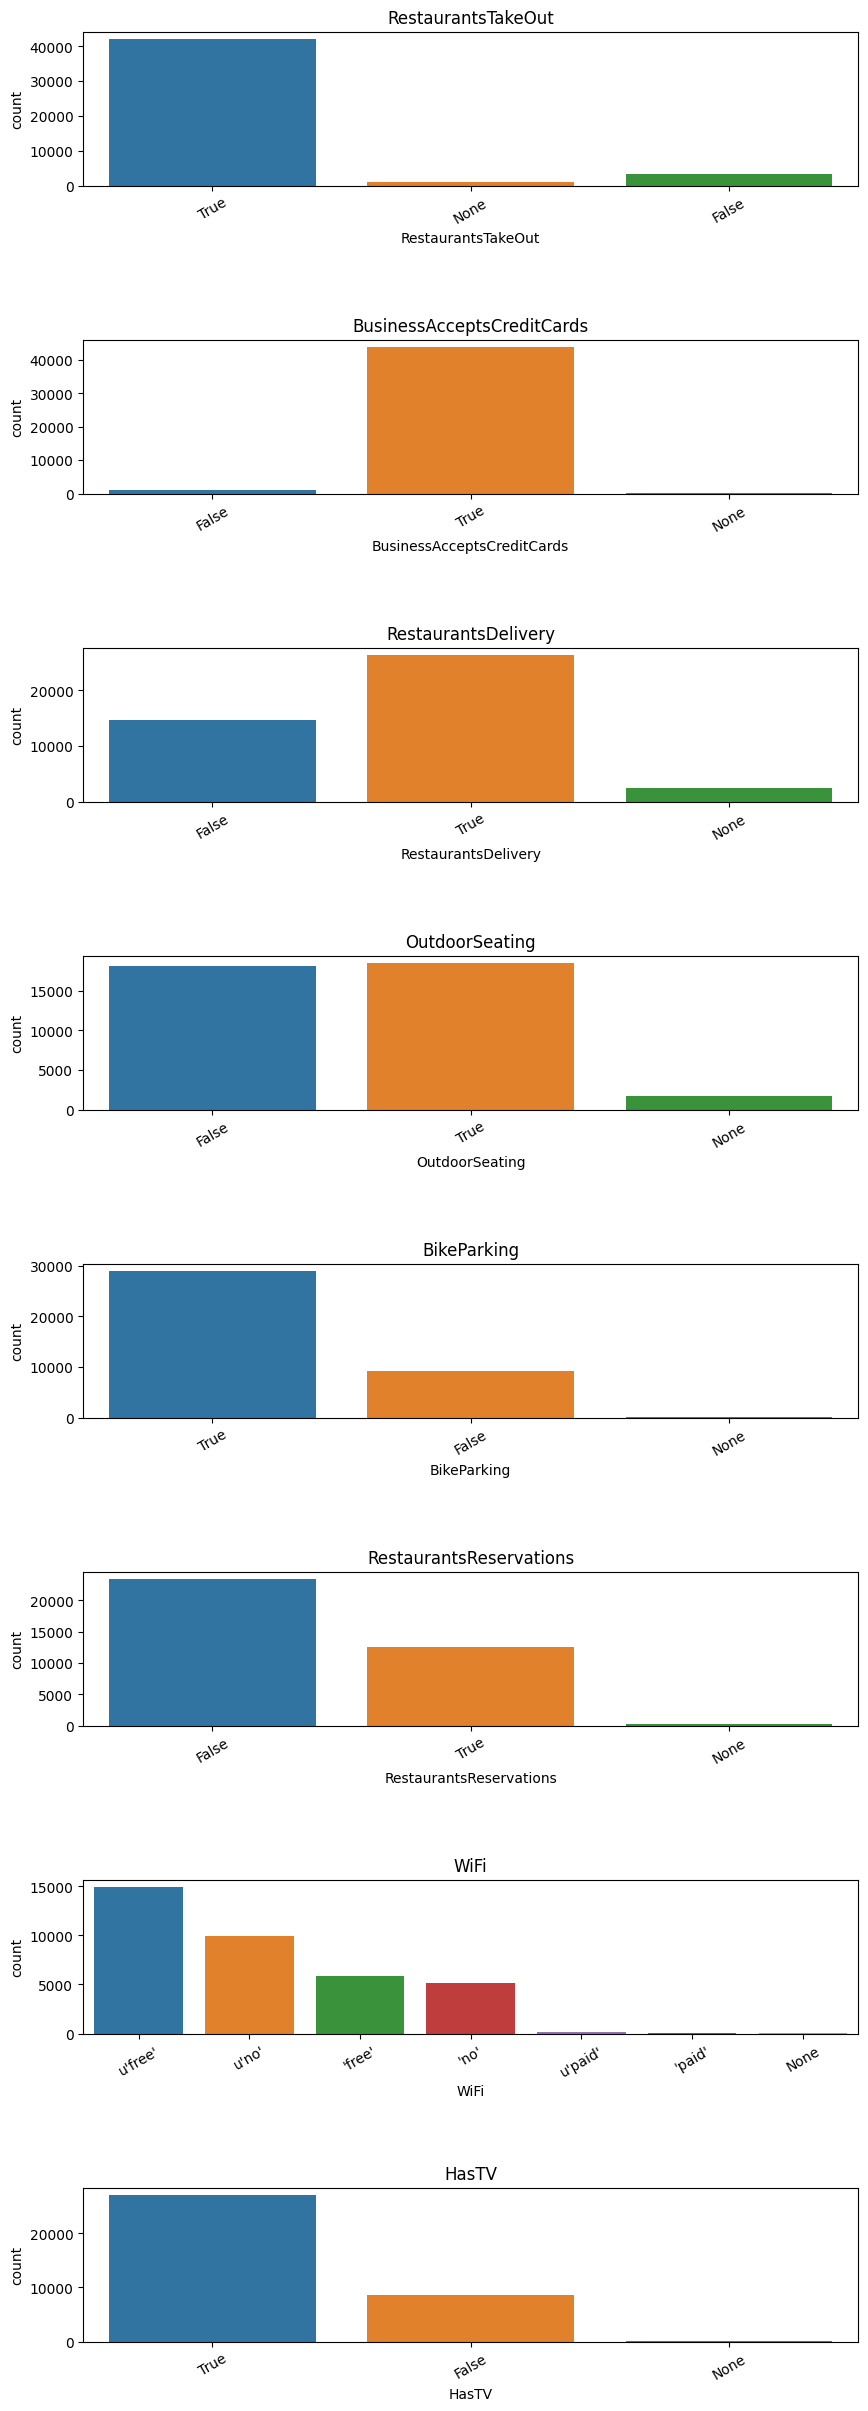

In [91]:
# Graficando algunos campos y sus categorias


#columnas = ['RestaurantsTakeOut', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 
#            'OutdoorSeating', 'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV']

columnas =['RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
            'RestaurantsDelivery', 'OutdoorSeating',
            'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV']


#columnas =['RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
#            'RestaurantsDelivery', 'OutdoorSeating',
#            'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'A_M_Monday',
#            'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday',
#            'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday', 'A_M_Thursday',
#            'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday', 'A_T_Friday',
#            'A_N_Friday', 'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday',
#            'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday']



fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(10,30))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(columnas):
    sns.countplot(x=col, data=df_ML_promedios, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

Dado que existen pocos valores con el estatus de 'None', se procede a imputar por 'False' enlas siguientes columns:

### Imputando 'None' por 'False'a las Variables Categoricas

In [92]:
# Se cambian para el grupo de columnas:
# Valores None, 'None' a false
columnas = ['RestaurantsTakeOut', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 
            'OutdoorSeating', 'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV']

for col in columnas:
    df_ML_promedios[col].fillna(value='False', inplace=True)
    df_ML_promedios[col].replace({"None":'False'}, inplace=True)

In [93]:
# Se cambian para el grupo de columnas:
# "u'free'", "'free'", "'paid'", "u'paid'" -> 'True'
# None, 'None', "u'no'", "'no'"            -> 'False'
columnas = ['WiFi']

for col in columnas:
    #df_categoricas_business[col].fillna(value='False', inplace=True)
    df_ML_promedios[col].replace({"u'free'":'True'}, inplace=True)
    df_ML_promedios[col].replace({"'free'":'True'}, inplace=True)
    df_ML_promedios[col].replace({"'paid'":'True'}, inplace=True)
    df_ML_promedios[col].replace({"u'paid'":'True'}, inplace=True)
    df_ML_promedios[col].replace({"None":'False'}, inplace=True)
    df_ML_promedios[col].fillna(value='False', inplace=True)
    df_ML_promedios[col].replace({"u'no'":'False'}, inplace=True)
    df_ML_promedios[col].replace({"'no'":'False'}, inplace=True) 

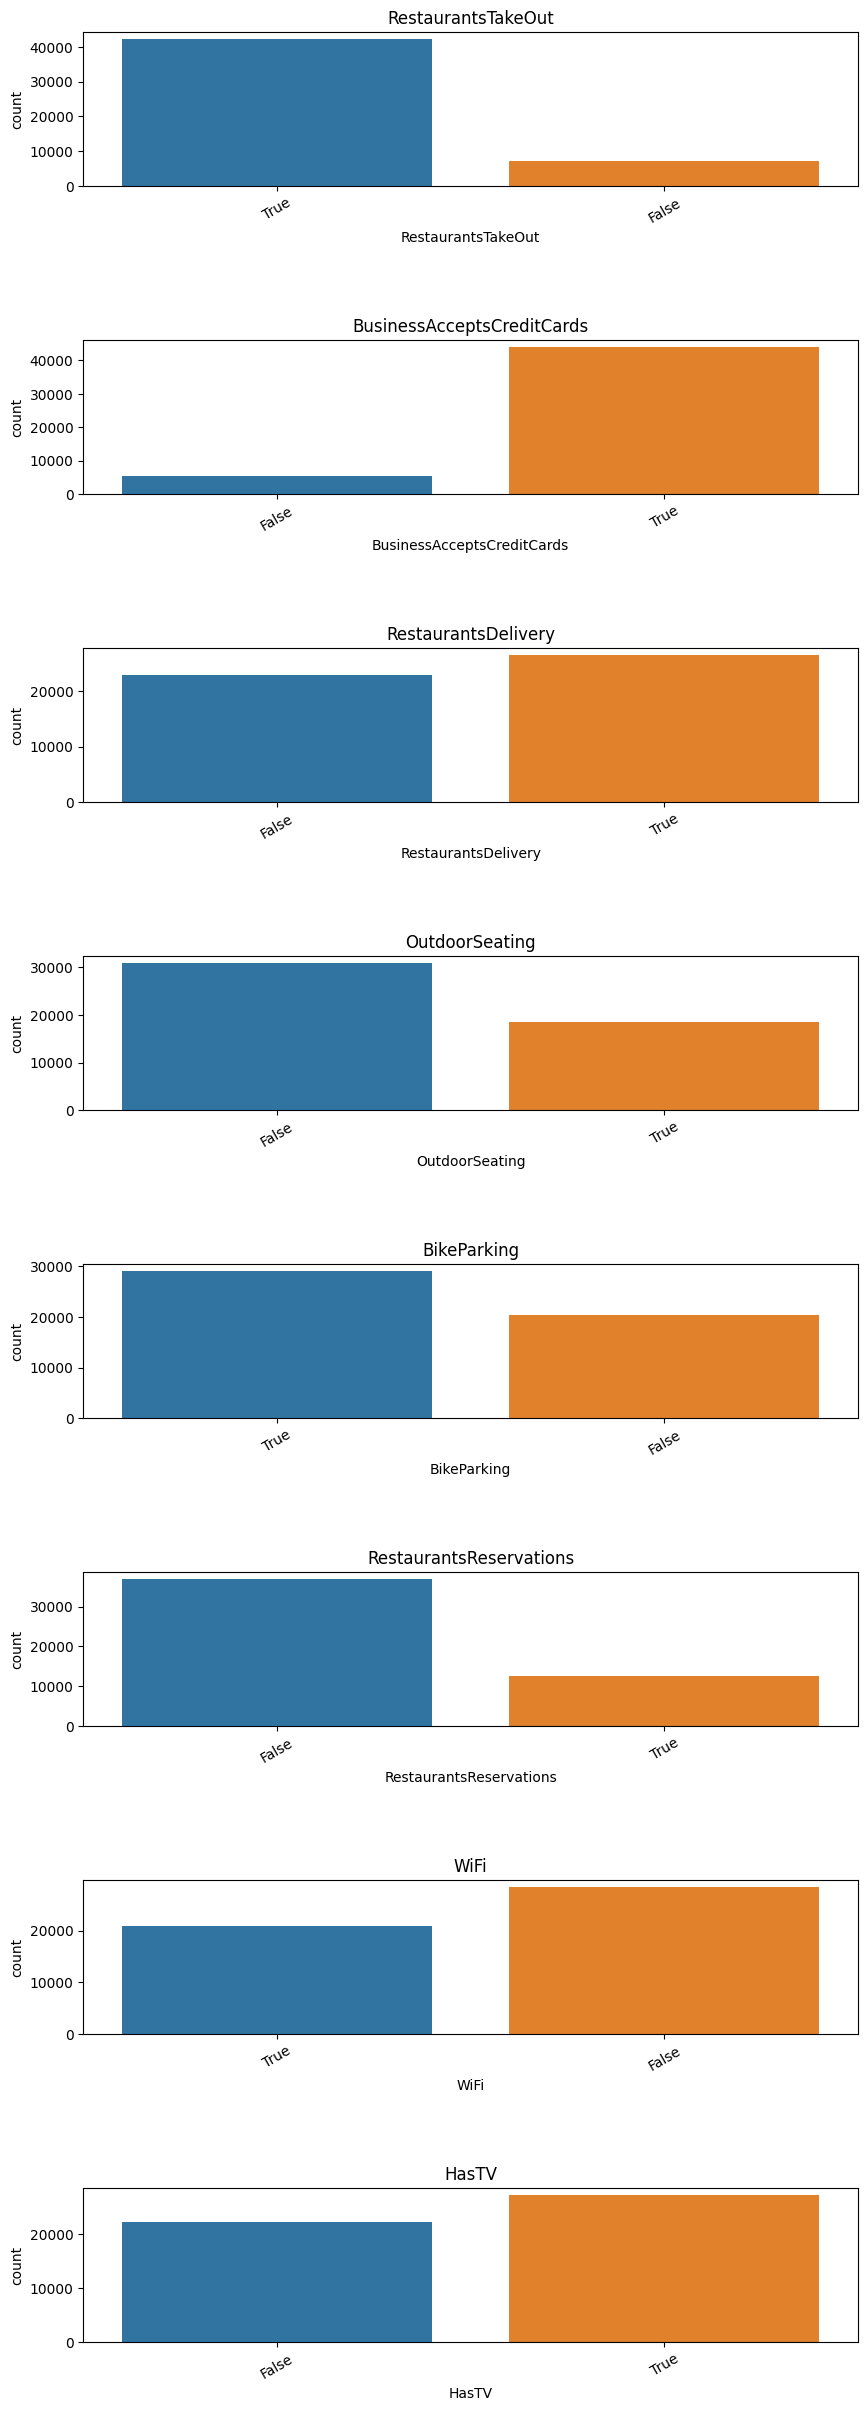

In [94]:
# Graficando algunos campos y sus categorias

columnas = ['RestaurantsTakeOut', 'BusinessAcceptsCreditCards', 'RestaurantsDelivery', 
            'OutdoorSeating', 'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV']

fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(10,30))
fig.subplots_adjust(hspace=1)

for i, col in enumerate(columnas):
    sns.countplot(x=col, data=df_ML_promedios, ax=ax[i])
    ax[i].set_title(col)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=30)

### OneHotEncoding 

In [102]:
df_variables_categoricas.shape

(49334, 37)

In [103]:
df_variables_categoricas.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'RestaurantsTakeOut', 'BusinessParking', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'A_M_Monday',
       'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday',
       'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday', 'A_M_Thursday',
       'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday', 'A_T_Friday',
       'A_N_Friday', 'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday',
       'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday'],
      dtype='object')

### Variables Categoricas de tipo Objeto 

In [113]:
### Variables Categoricas de tipo Objeto 

# Inicializa una lista para almacenar los nombres de las columnas
columnas_con_true_false = []

# Itera a través de las columnas del DataFrame
for columna in df_variables_categoricas.columns:
    # Verifica si la columna contiene las cadenas 'True' o 'False'
    if df_ML_promedios[columna].isin(['True', 'False']).any():
        columnas_con_true_false.append(columna)

# Lista de columnas que contienen 'True' o 'False'
print(f"Total de Columnas con 'True' o 'False': {len(columnas_con_true_false)}")
columnas_con_true_false


Total de Columnas con 'True' o 'False': 8


['RestaurantsTakeOut',
 'BusinessAcceptsCreditCards',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'BikeParking',
 'RestaurantsReservations',
 'WiFi',
 'HasTV']

### Convertiendo las Variables Categoricas de tipo Objeto 'True' y 'False' a Uno(1) y Ceros(0), respectivamente.

In [115]:
# Se cambian las columnas:
# 'True' -> 1
# 'False' -> 0

# columnas_con_true_false = Columnas que contienen 'True' y 'False'

for col in columnas_con_true_false:
    df_ML_promedios[col].replace({"True":1}, inplace=True)
    df_ML_promedios[col].replace({"False":0}, inplace=True)

In [117]:
df_ML_promedios.head(1).T

,0
business_id,MTSW4McQd7CbVtyjqoe9mw
name,St Honore Pastries
address,935 Race St
city,Philadelphia
state,CA
...,...
A_N_Saturday,False
A_M_Sunday,True
A_T_Sunday,False
A_N_Sunday,False


In [124]:
columnas_horario_bool =[
            'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 
            'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday',
            'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday', 
            'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 
            'A_M_Friday', 'A_T_Friday', 'A_N_Friday', 
            'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday',
            'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday']

In [136]:
# Inicializa una lista para almacenar los nombres de las columnas
columnas_bool_con_true_false = []

# Itera a través de las columnas del DataFrame
for columna in df_ML_promedios.columns:
    # Verifica si algún valor en la columna es True o False
    if df_ML_promedios[columna].dtype == bool and df[columna].any():
        columnas_bool_con_true_false.append(columna)

# 'columnas_con_true_false' contendrá los nombres de las columnas booleanas que contienen True o False
print("Columnas booleanas con True o False:")
print(columnas_bool_con_true_false)


Columnas booleanas con True o False:
['A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday', 'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday', 'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday', 'A_T_Friday', 'A_N_Friday', 'A_M_Saturday', 'A_T_Saturday', 'A_N_Saturday', 'A_M_Sunday', 'A_T_Sunday', 'A_N_Sunday']


In [137]:
for col in columnas_bool_con_true_false:
    df_ML_promedios[col] = df_ML_promedios[col].replace({True: 1, False: 0})

df_ML_promedios.head(1).T   

,0
business_id,MTSW4McQd7CbVtyjqoe9mw
name,St Honore Pastries
address,935 Race St
city,Philadelphia
state,CA
...,...
A_N_Saturday,0
A_M_Sunday,1
A_T_Sunday,0
A_N_Sunday,0


In [138]:
df_ML_promedios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49334 entries, 0 to 49333
Data columns (total 61 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   business_id                         49334 non-null  object 
 1   name                                49334 non-null  object 
 2   address                             49334 non-null  object 
 3   city                                49334 non-null  object 
 4   state                               49334 non-null  object 
 5   postal_code                         49334 non-null  object 
 6   latitude                            49334 non-null  float64
 7   longitude                           49334 non-null  float64
 8   stars                               49334 non-null  float64
 9   review_count                        49334 non-null  int16  
 10  is_open                             49334 non-null  int8   
 11  RestaurantsTakeOut                  49334

In [139]:
df_ML_promedios.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'RestaurantsTakeOut', 'BusinessParking', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'RestaurantsPriceRange2', 'OutdoorSeating',
       'BikeParking', 'RestaurantsReservations', 'WiFi', 'HasTV', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'average_stars', 'total_sentimientos',
       'promedio_sentimientos_positivos', 'promedio_sentimientos_negativos',
       'Promedio_useful', 'Promedio_funny', 'Promedio_cool',
       'total_sentimientosTip', 'promedio_sentimientos_positivosTip',
       'promedio_sentimientos_negativosTip', 'promedio_compliment_count_Tip',
       'A_M_Monday', 'A_T_Monday', 'A_N_Monday', 'A_M_Tuesday', 'A_T_Tuesday',
       'A_N_Tuesday', 'A_M_Wednesday', 'A_T_Wednesday', 'A_N_Wednesday',
       'A_M_Thursday', 'A_T_Thursday', 'A_N_Thursday', 'A_M_Friday',
   

### Guardando Datasets Consolidado FINAL para Análisis de ML (Promedios)

In [141]:
### Respaldando archivo en formato 'PARQUET'
Ubicacion = "gs://gmy/Datasets_ML"
NombreDelArchivo = 'df_ML_promedios_Final'
Extension = '.parquet'
file = os.path.join(Ubicacion, NombreDelArchivo) + Extension
df_ML_promedios.to_parquet(file)

### Graficando el Mapa de los 54789 Registros del DataSets de ML

In [ ]:
import pandas as pd
import folium
import webbrowser
import textwrap
from folium.plugins import MarkerCluster

df = df_ML_totales.copy()

map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], 
                zoom_start=7, control_scale=True)

marker_cluster = MarkerCluster().add_to(map)

title = 'Proyecto Yelp & Google Maps - Reseñas y Recomendaciones </br> Proyecto Final Grupo Nº 7 </br>@utores: Javier Castro, Luca Ramallo, Luis Ramírez, Lesmen García'
title_html = '<h3 align="center" style="font-size:16px"><b>{}</b></h3>'.format(title)


#Loop through each row in the dataframe
for i,row in df.iterrows():
    
        
    # Formatting the text1
    text1 = f"Name: <strong>{row['name']}</strong></br> \
    Address: <strong>{row['address']}</strong></br> \
    City: <strong>{row['city']}</strong></br> \
    State: <strong>{row['state']}</strong></br>  \
    Postal_code: <strong>{row['postal_code']}</strong></br> \
    Stars: <strong>{row['stars']}</strong></br> \
    Latitude: <strong>{row['latitude']}</strong></br> \
    Longitude: <strong>{row['longitude']}</strong></br> \
    Review_count: <strong>{row['review_count']}</strong> \
    </br> "

    # Formatting the text2 = ATRIBUTOS
    text2 = f"RestaurantsTakeOut: <strong>{row['RestaurantsTakeOut']}</strong></br>\
    BusinessParking: <strong>{row['BusinessParking']}</strong></br> \
    BusinessAcceptsCreditCards: <strong>{row['BusinessAcceptsCreditCards']}</strong></br> \
    RestaurantsDelivery: <strong>{row['RestaurantsDelivery']}</strong></br> \
    RestaurantsPriceRange2: <strong>{row['RestaurantsPriceRange2']}</strong></br> \
    OutdoorSeating: <strong>{row['OutdoorSeating']}</strong></br> \
    BikeParking: <strong>{row['BikeParking']} </strong></br>\
    RestaurantsReservations: <strong>{row['RestaurantsReservations']}</strong></br> \
    WiFi: <strong>{row['WiFi']}</strong></br> \
    HasTV: <strong>{row['HasTV']}</strong></br> \
    </br>"
        

    #Initialise the popup using the iframe
    text2 = folium.Popup(text2, min_width=300, max_width=450)  # Size Text2    OC_FechaCierreIncidente
    
    
    folium.Marker(location=[row['latitude'],row['longitude']],
                popup = text2, tooltip =  text1,
                icon=folium.Icon( prefix='fa') ).add_to(marker_cluster)  

map.get_root().html.add_child(folium.Element(title_html))
#map.save("MapaPF_Grupo07.html")    
map

### Fin